In [1]:
from classes.MedSAMClass import MedSAMInferer
import numpy as np
import nibabel as nib

import utils.prompt as prUt
import utils.analysis as anUt
from utils.image import read_im_gt
from utils.base_classes import Boxes

# Obtain model, image, gt
device = 'cuda'
medsam_checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/medsam_vit_b.pth'

medsam_inferer = MedSAMInferer(medsam_checkpoint_path, device)

img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/imagesTr/BDMAP_00000001_0000.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_2img/labelsTr/BDMAP_00000001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 3)
class_label = 3

gt_unprocessed = nib.load(gt_path).get_fdata()
gt_unprocessed = np.where(gt_unprocessed == class_label, 1, 0)

In [55]:
from importlib import reload
import utils.class_MedSAM as c
reload(c)
medsam_inferer = c.MedSAMInferer(medsam_checkpoint_path, device)


In [56]:
# Experiment: 2d bounding box per slice with foreground
medsam_inferer.set_image(img_path)
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)
# box_prompt = Boxes(box_prompt.boxes)
segmentation = medsam_inferer.predict(box_prompt).get_fdata()
anUt.compute_dice(segmentation, gt_unprocessed)

Performing inference on slices: 100%|██████████| 45/45 [00:07<00:00,  5.86it/s]


0.9523613963039015

In [3]:
# Experiment: get 3d bbox and slice it to feed it in 2d axially
box_prompt = prUt.get_bbox3d_sliced(gt)

segmentation = medsam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 45/45 [00:00<00:00, 189.40it/s]


0.8085227994411279

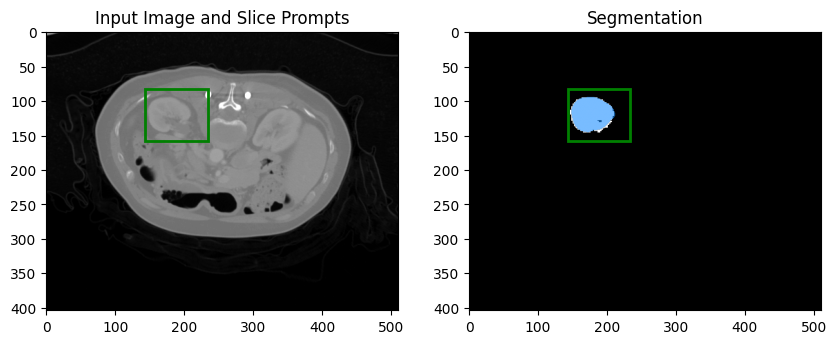

0.9598882458591099

In [4]:
slice_idx = 144
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, box_prompt= box_prompt)

In [5]:
# Experiment: Box interploation
n_boxes = 5

seed_boxes = prUt.get_seed_boxes(gt, n_boxes)
box_prompt = prUt.box_interpolation(seed_boxes)
segmentation = medsam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 45/45 [00:00<00:00, 174.85it/s]


0.8719548694879283

In [6]:
# Experiment: Box propagation

seed_box = prUt.get_seed_box(gt)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation, all_boxes = prUt.box_propagation(medsam_inferer, img, seed_box, slices_to_infer)

print(anUt.compute_dice(gt,segmentation))

Propagating down:  36%|███▋      | 8/22 [00:00<00:01, 12.91it/s]/home/t722s/Desktop/UniversalModels/Project/UniversalInterface/utils/prompt.py:504: UserWarning: 
Terminate early: no fg generated
  warnings.warn('\nTerminate early: no fg generated')
Propagating up:  41%|████      | 9/22 [00:00<00:00, 14.22it/s]/home/t722s/Desktop/UniversalModels/Project/UniversalInterface/utils/prompt.py:531: UserWarning: 
Terminate early: no fg generated
  warnings.warn('\nTerminate early: no fg generated')
Propagating up:  45%|████▌     | 10/22 [00:00<00:00, 12.63it/s]


0.33664004007406545


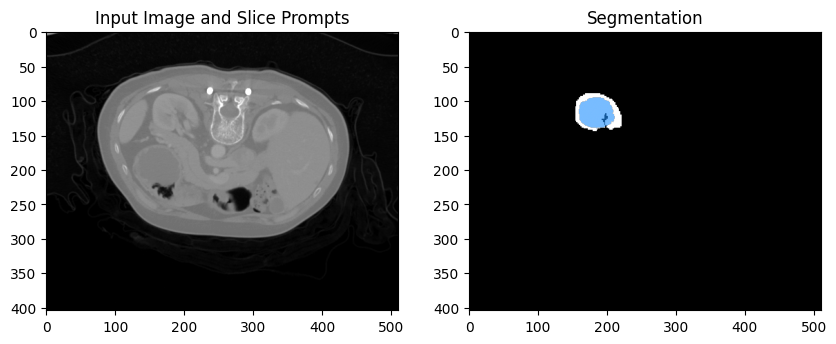

0.7550371155885471

In [7]:
# Slice visualisation:
slice_idx = 150
anUt.show_seg_row_major(slice_idx, img, gt, segmentation) #, pts_prompt= pts_prompt, box_prompt = box_prompt)